## Importing and prepping data

In [1]:
import pandas as pd
import numpy as np
import diff_classifier.aws as aws
import diff_classifier.pca as pca
import os

In [2]:
features = []
remote_folder = 'Gel_studies' #Folder in AWS S3 containing files to be analyzed
bucket = 'dtoghani.data'
vids = 10
mws = ['5k_PEG', 'PS_COOH', '5k_PEG_NH2', 'PS_NH2']
nonnum = ['Particle Type', 'Video Number', 'Track_ID', 'Deff2',
          'Mean Mean_Intensity', 'Std Mean_Intensity',
          'X', 'Y', 'Mean X', 'Mean Y', 'Std X', 'Std Y']
calcs = [3]

counter = 0
for calc in calcs:
    for mw in mws:
        for num in range(1, vids+1):
            try:
                filename = 'features_{}_{}mM_XY{}.csv'.format(mw, calc, '%02d' % num)
                #os.remove(filename)
                aws.download_s3('{}/{}'.format(remote_folder, filename), filename, bucket_name=bucket)
                fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
                fstats['Particle Type'] = pd.Series(fstats.shape[0]*[mw], index=fstats.index)
                fstats['Video Number'] = pd.Series(fstats.shape[0]*[num], index=fstats.index)
                #fstats['Calcium Concentration'] = pd.Series(fstats.shape[0]*[str(calcs)], index=fstats.index)
                #print(num)
                print(filename)
                counter = counter + 1
                if counter == 1:
                    fstats_tot = fstats
                else:
                    fstats_tot = fstats_tot.append(fstats, ignore_index=True)
            except:
                print('skip filename: {}'.format(filename))

features_5k_PEG_3mM_XY01.csv
features_5k_PEG_3mM_XY02.csv
features_5k_PEG_3mM_XY03.csv
features_5k_PEG_3mM_XY04.csv
features_5k_PEG_3mM_XY05.csv
features_5k_PEG_3mM_XY06.csv
features_5k_PEG_3mM_XY07.csv
features_5k_PEG_3mM_XY08.csv
features_5k_PEG_3mM_XY09.csv
features_5k_PEG_3mM_XY10.csv
features_PS_COOH_3mM_XY01.csv
features_PS_COOH_3mM_XY02.csv
features_PS_COOH_3mM_XY03.csv
features_PS_COOH_3mM_XY04.csv
features_PS_COOH_3mM_XY05.csv
features_PS_COOH_3mM_XY06.csv
features_PS_COOH_3mM_XY07.csv
features_PS_COOH_3mM_XY08.csv
features_PS_COOH_3mM_XY09.csv
features_PS_COOH_3mM_XY10.csv
features_5k_PEG_NH2_3mM_XY01.csv
features_5k_PEG_NH2_3mM_XY02.csv
features_5k_PEG_NH2_3mM_XY03.csv
features_5k_PEG_NH2_3mM_XY04.csv
features_5k_PEG_NH2_3mM_XY05.csv
features_5k_PEG_NH2_3mM_XY06.csv
features_5k_PEG_NH2_3mM_XY07.csv
features_5k_PEG_NH2_3mM_XY08.csv
features_5k_PEG_NH2_3mM_XY09.csv
features_5k_PEG_NH2_3mM_XY10.csv
features_PS_NH2_3mM_XY01.csv
features_PS_NH2_3mM_XY02.csv
features_PS_NH2_3mM_XY

In [3]:
nonnum = ['Particle Type', 'Video Number', 'Track_ID', 'Mean Mean_Intensity', 'Std Mean_Intensity', 'X', 'Y', 'Quality',
          'Mean_Intensity', 'SN_Ratio', 'Mean X', 'Std X', 'Mean Y', 'Std Y', 'Mean Quality', 'Std Quality', 'Mean SN_Ratio',
          'Std SN_Ratio', 'binx', 'biny', 'bins']

## Train-Test Split

In [4]:
bins = list(range(0, 2048+1, 256))
fstats_tot['binx'] = pd.cut(fstats_tot.X, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7])
fstats_tot['biny'] = pd.cut(fstats_tot.Y, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7])
fstats_tot['bins'] = 8*fstats_tot['binx'] + fstats_tot['biny']
fstats_tot = fstats_tot[np.isfinite(fstats_tot.bins)]
fstats_tot.bins = fstats_tot.bins.astype(int)

In [5]:
# cols = fstats_tot.columns.tolist()
# cols = cols[-3:] + cols[:-3]
# pcadataset.final = pcadataset.final[cols]

def checkerboard(size):
    rows = int(size/2)
    checks = list(range(0, size*size, size+1))
    
    for i in range(1, rows):
        ssize = size - 2*i
        for j in range(0, ssize):
            checks.append(2*i + (size+1)*j)

    for i in range(1, rows):
        ssize = size - 2*i
        for j in range(0, ssize):
            checks.append(size*size - 1 - (2*i + (size+1)*j))
    checks.sort()
    return checks

In [6]:
featofvar = 'Particle Type'
#ncomp = 15

# X_train = pcadataset.final[pcadataset.final.bins.isin(checkerboard(8))].values[:, -ncomp:]
# X_test = pcadataset.final[~pcadataset.final.bins.isin(checkerboard(8))].values[:, -ncomp:]
# y_train = pcadataset.final[pcadataset.final.bins.isin(checkerboard(8))][featofvar].values
# y_test = pcadataset.final[~pcadataset.final.bins.isin(checkerboard(8))][featofvar].values

f_train = fstats_tot[fstats_tot.bins.isin(checkerboard(8))].reset_index()
f_test = fstats_tot[~fstats_tot.bins.isin(checkerboard(8))].reset_index()

# for run in range(1):
#     clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
#                         alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
#                         early_stopping=True, validation_fraction=0.1)

#     clf.fit(X_train, y_train)
    
#     print('Training Results')
#     y_true1, y_pred1 = y_train, clf.predict(X_train)
#     print(classification_report(y_true1, y_pred1, digits=4))
    
#     print('Test Results')
#     print()
#     y_true, y_pred = y_test, clf.predict(X_test)
#     print(classification_report(y_true, y_pred, digits=4))

## PCA analysis

The pca.pca_analysis function provides a completely contained PCA analysis of the input trajectory features dataset. It includes options to impute NaN values (fill in with average values or drop them), and to scale features. Read the docstring for more information. 

In [8]:
ncomp = 12
pca_train = pca.pca_analysis(f_train, dropcols=nonnum, n_components=ncomp)

Cumulative explained variance:
0 component: 0.28051354448615773
1 component: 0.4200961016937248
2 component: 0.5149357582884654
3 component: 0.5636008789226776
4 component: 0.6076405461699509
5 component: 0.64609384941029
6 component: 0.6832471377190785
7 component: 0.7117510587604907
8 component: 0.7389676072878353
9 component: 0.7644361424390774
10 component: 0.788208430669532
11 component: 0.8074855803240709


The pca.kmo function calculates the Kaiser-Meyer-Olkin statistic, a measure of sampling adequacy. Check the docstring for more information.

In [9]:
kmostat = pca.kmo(pca_train.scaled)

0.894980717314


In [10]:
pca_train.final.head()

,index,Track_ID,alpha,D_fit,kurtosis,asymmetry1,asymmetry2,asymmetry3,AR,elongation,...,2,3,4,5,6,7,8,9,10,11
0,0,0.0,2.087722,0.009921,3.288073,0.687821,0.305425,0.152625,1.645260,0.392193,...,-0.466200,-2.426054,-2.407742,0.451686,-2.043483,1.335264,-0.361133,-0.144198,0.035404,-0.124435
1,1,1.0,0.605314,2.999583,2.839747,0.491746,0.419057,0.087519,2.218964,0.549339,...,-0.354438,-2.087036,0.200616,-0.695486,-0.747331,-0.185309,0.028920,-0.393201,0.445832,-0.167628
2,3,3.0,3.905291,0.000002,2.819551,0.746835,0.269905,0.180644,1.196063,0.163924,...,0.574785,-1.982904,-0.100222,0.392486,1.352531,-0.192328,1.477960,0.216087,-0.547321,1.767483
3,10,10.0,0.196917,3.784709,2.421901,0.768053,0.256668,0.192301,2.053960,0.513136,...,-0.577699,-2.731545,2.035053,-3.217798,-1.468654,0.538751,1.116242,-0.689398,-0.238753,-0.610051
4,12,12.0,1.236549,0.125187,5.491608,0.009045,0.909014,0.001136,1.184633,0.155856,...,-2.598945,-2.577968,-0.350039,0.215150,1.855970,0.041259,1.467033,0.082089,-0.564750,-0.822756


In [11]:
pca_test = pca.pca_analysis(f_test, dropcols=nonnum, n_components=ncomp, existing_model=True, model_file=pca_train)

## Visualization

Users can then compare average principle component values between subgroups of the data. In this case, all particles were taken from the same sample, so there are no experimental subgroups. I chose to compare short trajectories to long trajectories, as I would expect differences between the two groups.

In [12]:
import numpy as np
#ncomp = 10
dicti = {}
#test = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==200].as_matrix()), axis=0))[-6:]
#test1 = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==500].as_matrix()), axis=0))[-6:]
dicti[0] = np.nanmean(pca_train.final[pca_train.final['Particle Type']=='5k_PEG'].values[:, -ncomp:], axis=0)
dicti[1] = np.nanmean(pca_train.final[pca_train.final['Particle Type']=='5k_PEG_NH2'].values[:, -ncomp:], axis=0)
dicti[2] = np.nanmean(pca_train.final[pca_train.final['Particle Type']=='PS_COOH'].values[:, -ncomp:], axis=0)
dicti[3] = np.nanmean(pca_train.final[pca_train.final['Particle Type']=='PS_NH2'].values[:, -ncomp:], axis=0)

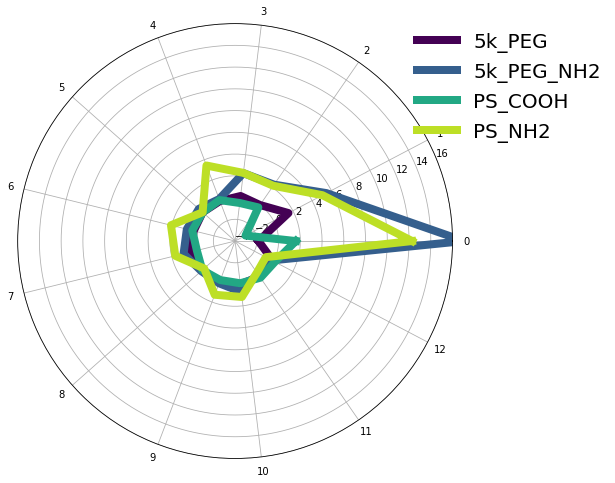

In [23]:
labels = ['5k_PEG', '5k_PEG_NH2', 'PS_COOH', 'PS_NH2']
pca.plot_pca(dicti, savefig=True, labels=labels, rticks=np.linspace(-4, 16, 11), filename='surfacefunc3_pcaavg.png')

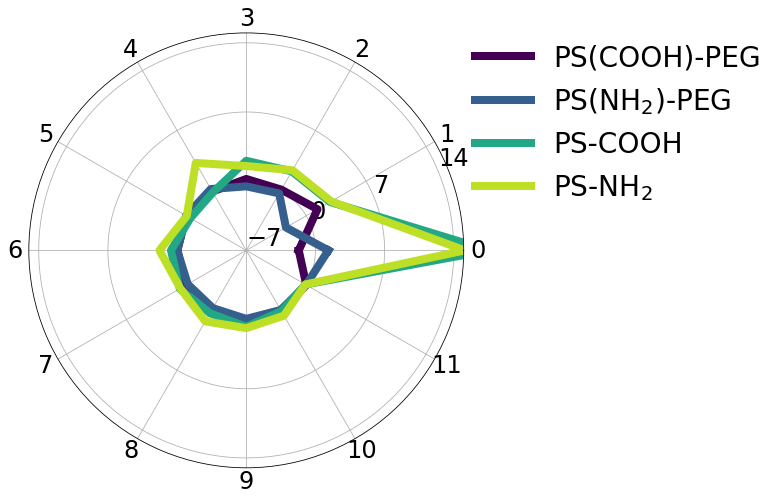

In [13]:
labels = ['5k_PEG', '5k_PEG_NH2', 'PS_COOH', 'PS_NH2']
labels2 = ['PS(COOH)-PEG', r'PS(NH$_{2}$)-PEG', 'PS-COOH', r'PS-NH$_{2}$']
pca.plot_pca(dicti, savefig=True, labels=labels2, rticks=np.linspace(-7, 14, 4), dpi=300, labelsize=24,
             filename='pics/sf3_pcaavg.png')

The variable pcadataset.prcomps shows the user the major contributions to each of the new principle components. When observing the graph above, users can see that there are some differences between short trajectories and long trajectories in component 0 (asymmetry1 being the major contributor) and component 1 (elongation being the major contributor).

In [13]:
pcadataset.prcomps

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Mean straightness,Mean_Intensity,asymmetry3,Quality,Std asymmetry1,frames,alpha,Std kurtosis,Std boundedness,Std SN_Ratio,Std trappedness,Std MSD_ratio,Std kurtosis
1,Mean fractal_dim,Mean Quality,elongation,trappedness,Std asymmetry2,trappedness,Std asymmetry1,D_fit,Std trappedness,Mean SN_Ratio,Std boundedness,Mean MSD_ratio,Mean kurtosis
2,Mean efficiency,Std asymmetry3,asymmetry2,boundedness,alpha,boundedness,Std asymmetry2,Mean kurtosis,kurtosis,Std MSD_ratio,Deff1,Std trappedness,Std Quality
3,Mean trappedness,Std AR,asymmetry1,Mean Quality,MSD_ratio,straightness,D_fit,SN_Ratio,Deff1,Mean MSD_ratio,kurtosis,Std boundedness,Mean frames
4,Mean boundedness,Mean AR,AR,Std D_fit,efficiency,D_fit,Mean MSD_ratio,Deff1,D_fit,SN_Ratio,Mean AR,Std SN_Ratio,Std frames


In [14]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns
def feature_violin(df, label='label', lvals=['yes', 'no'], fsubset=3, **kwargs):
    """Creates violinplot of input feature dataset

    Designed to plot PCA components from pca_analysis.

    Parameters
    ----------
    df : pandas.core.frames.DataFrame
        Must contain a group name column, and numerical feature columns.
    label : string or int
        Name of group column.
    lvals : list of string or int
        All values that group column can take
    fsubset : int or list of int
        Features to be plotted. If integer, will plot range(fsubset).
        If list, will only plot features contained in fsubset.
    **kwargs : variable
        figsize : tuple of int or float
            Dimensions of output figure
        yrange : list of int or float
            Range of y axis
        xlabel : string
            Label of x axis
        labelsize : int or float
            Font size of x label
        ticksize : int or float
            Font size of y tick labels
        fname : None or string
            Name of output file
        legendfontsize : int or float
            Font size of legend
        legendloc : int
            Location of legend in plot e.g. 1, 2, 3, 4

    """

    defaults = {'figsize': (12, 5), 'yrange': [-20, 20], 'xlabel': 'Feature',
                'labelsize': 20, 'ticksize': 16, 'fname': None,
                'legendfontsize': 12, 'legendloc': 1}

    for defkey in defaults.keys():
        if defkey not in kwargs.keys():
            kwargs[defkey] = defaults[defkey]

    # Restacking input data
    groupsize = []
    featcol = []
    valcol = []
    feattype = []

    if isinstance(fsubset, int):
        frange = range(fsubset)
    else:
        frange = fsubset

    for feat in frange:
        groupsize.extend(df[label].values)
        featcol.extend([feat]*df[label].values.shape[0])
        valcol.extend(df[feat].values)

    to_violind = {'label': groupsize, 'Feature': featcol,
                  'Feature Value': valcol}
    to_violin = pd.DataFrame(data=to_violind)

    # Plotting function
    fig, ax = plt.subplots(figsize=kwargs['figsize'])
    sns.violinplot(x="Feature", y="Feature Value", hue="label", data=to_violin,
                   palette=cm.viridis(np.linspace(0, 0.9, 4)), hue_order=lvals,
                   figsize=kwargs['figsize'], linewidth=0)

    # kwargs
    ax.tick_params(axis='both', which='major', labelsize=kwargs['ticksize'])
    plt.xlabel('Feature', fontsize=kwargs['labelsize'])
    plt.ylabel('Normalized\nFeature Space', fontsize=kwargs['labelsize'])
    plt.ylim(kwargs['yrange'])
    plt.legend(loc=kwargs['legendloc'], prop={'size': kwargs['legendfontsize']})
    plt.setp(ax.collections, alpha=.75)
    if kwargs['fname'] is None:
        plt.show()
    else:
        plt.savefig(kwargs['fname'], dpi=1200, pad_inches=0.22)

    return to_violin

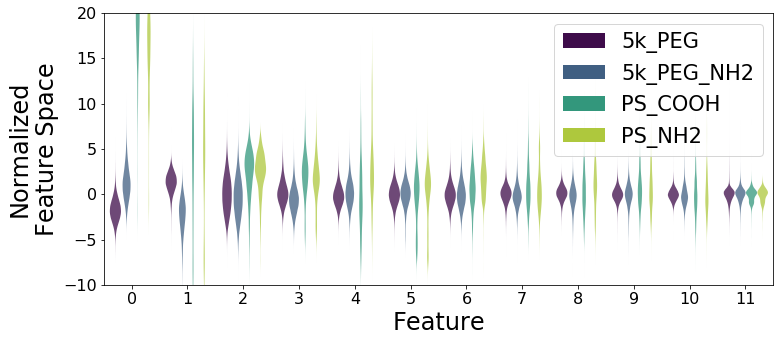

In [15]:
feats = feature_violin(pca_train.final, label='Particle Type', lvals=labels, labels=labels2, fsubset=ncomp, yrange=[-10, 20],
                       legendfontsize=21, labelsize=24, fname='./pics/sf3_pcadist.png')

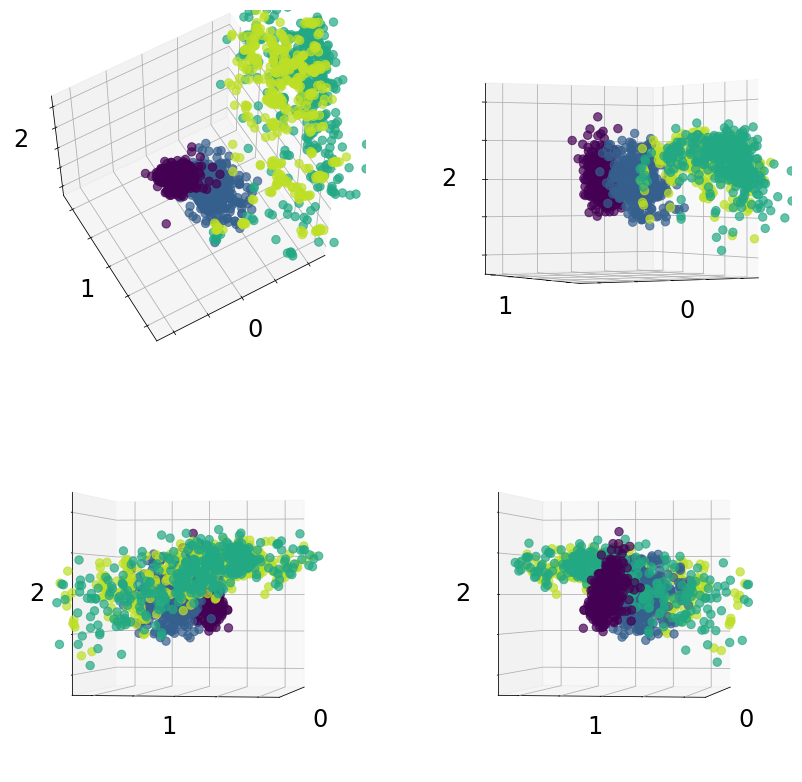

In [19]:
fstats1 = pca.feature_plot_3D(pca_train.final, label='Particle Type', lvals=labels, randcount=400, ylim=[-12, 12],
                              xlim=[-12, 12], zlim=[-12, 12], legendfontsize=24, labelfontsize=24, dpi=1600,
                              ticksize=20,
                              fname='./pics/sf3_3feats.png')

## Neural Network

In [17]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

In [18]:
X_train = pca_train.final.values[:, -ncomp:]
X_test = pca_test.final.values[:, -ncomp:]
y_train = pca_train.final[featofvar].values
y_test = pca_test.final[featofvar].values

for run in range(1):
    clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)

    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))

    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.09071477
Validation score: 0.968890
Iteration 2, loss = 0.06991678
Validation score: 0.973911
Iteration 3, loss = 0.06226507
Validation score: 0.976667
Iteration 4, loss = 0.05631020
Validation score: 0.980051
Iteration 5, loss = 0.05106211
Validation score: 0.980870
Iteration 6, loss = 0.04665934
Validation score: 0.983654
Iteration 7, loss = 0.04232558
Validation score: 0.985482
Iteration 8, loss = 0.03867858
Validation score: 0.988211
Iteration 9, loss = 0.03572811
Validation score: 0.990121
Iteration 10, loss = 0.03309654
Validation score: 0.988784
Iteration 11, loss = 0.03095043
Validation score: 0.990176
Iteration 12, loss = 0.02895370
Validation score: 0.991404
Iteration 13, loss = 0.02745918
Validation score: 0.991267
Iteration 14, loss = 0.02592432
Validation score: 0.991213
Iteration 15, loss = 0.02496223
Validation score: 0.992359
Iteration 16, loss = 0.02405419
Validation score: 0.992850
Iteration 17, loss = 0.02292553
Validation score: 0.992905
Iterat